<a href="https://colab.research.google.com/github/borisdayma/dalle-mini/blob/main/DALL%C2%B7E_mini_Inference_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use [the demo](https://huggingface.co/spaces/flax-community/dalle-mini) (temporarily in beta on Huging Face Spaces but soon to be open to all).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## Install dependencies

In [1]:
!pip install -q transformers flax
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git  # VQGAN model in JAX
!git clone https://github.com/borisdayma/dalle-mini  # Model files
%cd dalle-mini/

fatal: destination path 'dalle-mini' already exists and is not an empty directory.
/content/dalle-mini


## Generate encoded images

We generate prediction samples from a text prompt using the `flax-community/dalle-mini` model.

In [2]:
from dalle_mini.model import CustomFlaxBartForConditionalGeneration
from transformers import BartTokenizer
import jax
import random

In [3]:
# make sure we use compatible versions
DALLE_REPO = 'flax-community/dalle-mini'
DALLE_COMMIT_ID = '4d34126d0df8bc4a692ae933e3b902a1fa8b6114'

In [4]:
# set up tokenizer and model
tokenizer = BartTokenizer.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)
model = CustomFlaxBartForConditionalGeneration.from_pretrained(DALLE_REPO, revision=DALLE_COMMIT_ID)

INFO:absl:Starting the local TPU driver.
INFO:absl:Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
INFO:absl:Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.


In [5]:
# set a prompt
prompt = 'picture of a waterfall under the sunset'

In [6]:
# tokenize the prompt
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128)
tokenized_prompt

{'input_ids': DeviceArray([[    0, 37587,     9,    10, 35076,   223,     5, 18820,
                  2,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
                  1,     1,     1,     1,     1,     1,     1,     1,
      

Notes:

* `0`: BOS, special token representing the beginning of a sequence
* `2`: EOS, special token representing the end of a sequence
* `1`: special token representing the padding of a sequence when requesting a specific length

In [7]:
n_predictions = 8

# create random keys
seed = random.randint(0, 2**32-1)
key = jax.random.PRNGKey(seed)
subkeys = jax.random.split(key, num=n_predictions)
subkeys

DeviceArray([[3630291632, 1365705379],
             [ 519182379,  967263276],
             [3462576046, 1536800946],
             [3903976828,  742771997],
             [ 122202652, 3806694540],
             [4291156073,  563078600],
             [  29440102, 3821237308],
             [2070538234,  859418936]], dtype=uint32)

In [8]:
# generate sample predictions
encoded_images = [model.generate(**tokenized_prompt, do_sample=True, num_beams=1, prng_key=subkey) for subkey in subkeys]
encoded_images[0]

FlaxSampleOutput([('sequences',
                   DeviceArray([[16384,  7516,  3863, 13236,  7106,  8946, 13500, 13291,
                                  2127,  6690, 15575, 11348,  6660, 14420,  6948,  7160,
                                 15883, 15366,  9514,  2193,  1742, 11492, 15276,   194,
                                  6113, 14037, 11718, 10227,  4493,  3037,  4265,  3710,
                                  6808,   129, 10997,  9834,  1069,  3212,  3583,  1933,
                                  1133, 15387, 11228,  6060,  3272,  9589,  4682, 14008,
                                 14134, 13500, 10845,  1586,  9287, 14037, 11227, 10278,
                                  3812, 12623,  9453,  8283,  1139,  8283,  5918, 14134,
                                  1270, 10912,   134,  8408, 11110,  6756,  7896,  6331,
                                   129,  8361,  4816, 15910, 10121,  6601, 15881, 11716,
                                  5762, 10721,  9010,  9900,  4945,  6092, 125

The first token (`16384`) is a special token representing the start of a sequence in the decoder (not part of the image codebook).

In [9]:
# remove first token (BOS)
encoded_images = [img.sequences[..., 1:] for img in encoded_images]
encoded_images[0]

DeviceArray([[ 7516,  3863, 13236,  7106,  8946, 13500, 13291,  2127,
               6690, 15575, 11348,  6660, 14420,  6948,  7160, 15883,
              15366,  9514,  2193,  1742, 11492, 15276,   194,  6113,
              14037, 11718, 10227,  4493,  3037,  4265,  3710,  6808,
                129, 10997,  9834,  1069,  3212,  3583,  1933,  1133,
              15387, 11228,  6060,  3272,  9589,  4682, 14008, 14134,
              13500, 10845,  1586,  9287, 14037, 11227, 10278,  3812,
              12623,  9453,  8283,  1139,  8283,  5918, 14134,  1270,
              10912,   134,  8408, 11110,  6756,  7896,  6331,   129,
               8361,  4816, 15910, 10121,  6601, 15881, 11716,  5762,
              10721,  9010,  9900,  4945,  6092, 12566, 13050,  9957,
               3006, 10890,  4942, 13512,  7398,   321, 13050,  2987,
                602,  2129,  9325,  4395,   663,  7864,  3583, 11497,
              12143, 10121,  9479, 11110,  1847, 10019, 11591,  3932,
               3742,

The generated images are now represented by 256 tokens.

In [10]:
encoded_images[0].shape

(1, 256)

## Decode images

The generated images need to be decoded with `flax-community/vqgan_f16_16384`.

In [11]:
from vqgan_jax.modeling_flax_vqgan import VQModel
import numpy as np
from PIL import Image

In [12]:
# make sure we use compatible versions
VQGAN_REPO = 'flax-community/vqgan_f16_16384'
VQGAN_COMMIT_ID = '90cc46addd2dd8f5be21586a9a23e1b95aa506a9'

In [13]:
# set up VQGAN
vqgan = VQModel.from_pretrained(VQGAN_REPO, revision=VQGAN_COMMIT_ID)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


In [14]:
# decode images
decoded_images = [vqgan.decode_code(encoded_image) for encoded_image in encoded_images]
decoded_images[0]

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


DeviceArray([[[[0.3527669 , 0.42329234, 0.435171  ],
               [0.36237508, 0.45925468, 0.45632082],
               [0.35312858, 0.4199786 , 0.44490796],
               ...,
               [0.33345008, 0.33305386, 0.30364382],
               [0.3464288 , 0.3732767 , 0.3067937 ],
               [0.43649557, 0.47215104, 0.35043788]],

              [[0.34116623, 0.4119512 , 0.43873805],
               [0.357432  , 0.41660318, 0.4608935 ],
               [0.38340443, 0.42484534, 0.48160136],
               ...,
               [0.3752011 , 0.3397472 , 0.31144398],
               [0.3633617 , 0.3657545 , 0.30802566],
               [0.35559314, 0.33408147, 0.2997864 ]],

              [[0.34695795, 0.4252405 , 0.45974994],
               [0.35794052, 0.4226349 , 0.44932932],
               [0.3718857 , 0.4318006 , 0.4592569 ],
               ...,
               [0.28314543, 0.2834907 , 0.2275434 ],
               [0.27718377, 0.30525896, 0.21919258],
               [0.31285578, 0.30429

In [15]:
# normalize images
clipped_images = [img.squeeze().clip(0., 1.) for img in decoded_images]

In [16]:
# convert to image
images = [Image.fromarray(np.asarray(img * 255, dtype=np.uint8)) for img in clipped_images]

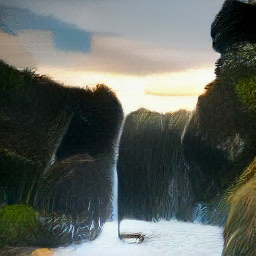

In [17]:
# display an image
images[0]

## Rank images with CLIP

We use `openai/clip-vit-base-patch32` to rank generated images against the prompt.

In [18]:
from transformers import CLIPProcessor, FlaxCLIPModel

# modules required for normalizing images
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [19]:
# set up model and processor
clip = FlaxCLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [20]:
# image pre-processing used by CLIP
def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        lambda image: image.convert("RGB"),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transforms = _transform(224)

In [21]:
# normalize images as expected by CLIP
normalized_images = [transforms(image) for image in images]

In [22]:
# evaluate scores
inputs = processor(text=prompt, images=normalized_images, return_tensors='np')
logits = clip(**inputs).logits_per_image
scores = jax.nn.softmax(logits, axis=0).squeeze()  # normalize and sum all scores to 1

Prompt: picture of a waterfall under the sunset

Score: 0.261961430311203


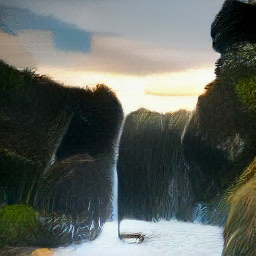


Score: 0.2412952035665512


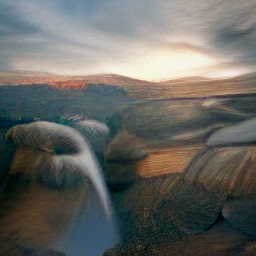


Score: 0.16171298921108246


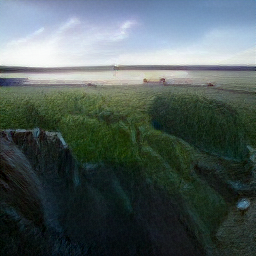


Score: 0.13704706728458405


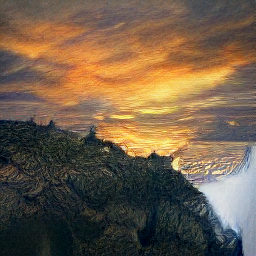


Score: 0.09979470074176788


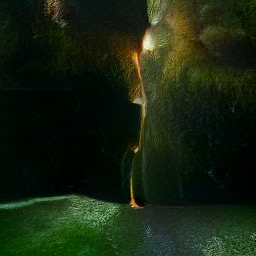


Score: 0.06281464546918869


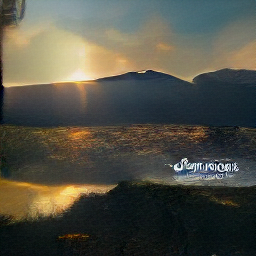


Score: 0.021453697234392166


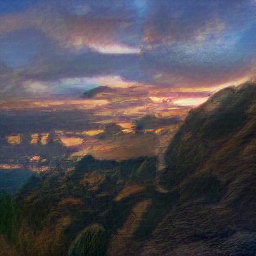


Score: 0.013920358382165432


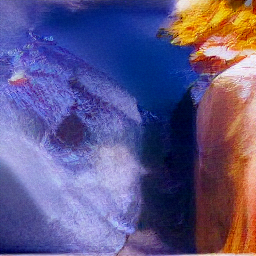

In [23]:
# rank images by score
print(f'Prompt: {prompt}\n')
for idx in scores.argsort()[::-1]:
    print(f'Score: {scores[idx]}')
    display(images[idx])
    print()

## Leverage JAX for faster inference

[JAX](https://github.com/google/jax) uses XLA to compile code to GPU/TPU, leading to faster inference, especially when multiple TPU devices are available.

In [24]:
from functools import partial
from flax.training.common_utils import shard
from flax.jax_utils import replicate

In [25]:
# check we can access TPU's or GPU's
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [26]:
# replicate parameters on all devices
dalle_params = replicate(model.params)
vqgan_params = replicate(vqgan.params)

/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:387: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  "jax.host_count has been renamed to jax.process_count. This alias "
/usr/local/lib/python3.7/dist-packages/jax/lib/xla_bridge.py:374: UserWarning: jax.host_id has been renamed to jax.process_index. This alias will eventually be removed; please update your code.
  "jax.host_id has been renamed to jax.process_index. This alias "


In [27]:
# one set of inputs per device
prompt = ['picture of a waterfall under the sunset'] * jax.device_count()

In [28]:
# tokenize prompts and shard them across available devices
tokenized_prompt = tokenizer(prompt, return_tensors='jax', padding='max_length', truncation=True, max_length=128).data
tokenized_prompt = shard(tokenized_prompt)

We use `pmap` to compile the functions with XLA and perform operations in parallel on multiple devices.

In [29]:
# parallelize and compile functions

# function to generate encoded images
@partial(jax.pmap, axis_name="batch")
def p_generate(tokenized_prompt, key, params):
    return model.generate(
        **tokenized_prompt,
        do_sample=True,
        num_beams=1,
        prng_key=key,
        params=params
    )

# function to decode images
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

In [30]:
# generate images with compiled functions
n_predictions = 8
images = []

for i in range(n_predictions // jax.device_count()):
    key, *subkeys = jax.random.split(key, jax.device_count() + 1)
    subkeys = jax.numpy.stack(subkeys)

    encoded_images = p_generate(tokenized_prompt, subkeys, dalle_params)
    encoded_images = encoded_images.sequences[..., 1:]

    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0., 1.).reshape((-1, 256, 256, 3))

    for img in decoded_images:
        images.append(Image.fromarray(np.asarray(img * 255, dtype=np.uint8)))

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


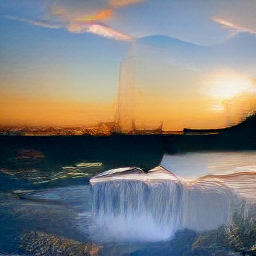

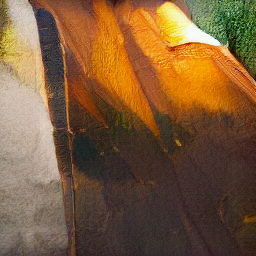

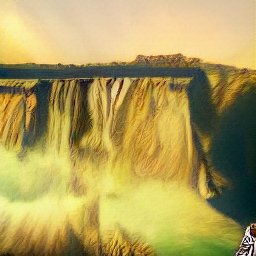

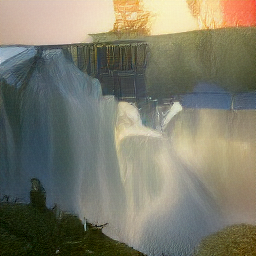

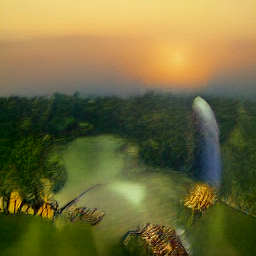

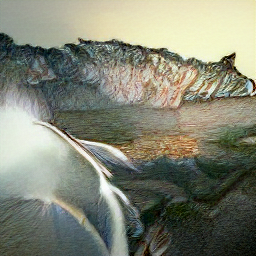

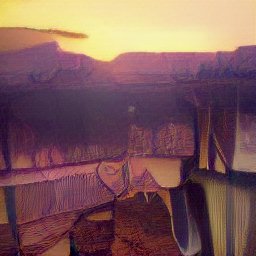

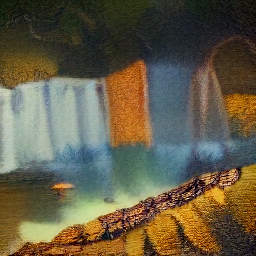

In [31]:
for img in images:
    display(img)
    print()